## Xtream AI assignement - Challenge 1

## Purpose
The outcome of this notebook will be a model that predicts a gem's worth based on its characteristics.

## Methodology

I will start reading some online content to make myself an idea of the topic and what usually the caracteristics that define a gem's worth are.



## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- finalize methodology
- results
- next steps
- un altro paper nel sota
- consider weighted loss function
- insert clas weights during training
- xboost regressor
- aggiusta corellation matrix drop dei feature dipendenti

## Results

## Suggested next steps
train a model etc

## SOTA and previous works

Extracted informations from [GEMO](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones):

"Value and beauty of gemstones depend heavily on the precision and quality of their cuts."
"...type of gemstone and considers various characteristics such as kind, color scheme, form, and weight to estimate its value"
"...The valuation of gemstones depends on multiple factors,
including color, cut, carat weight, and clarity..."

"...application of neural networks in regression problems involving qualitative data..."

Shape and weight are factors to keep under observation.

### Interesting findings

##### Approach:
Regression with Random Forest to predict the price

##### Pre-processing:
- cleaning
- train-test % split:  80-20

##### Performances evaluation metric:
RMSE, used to determine the degree of variation between expected and observed prices


TODO add another paper

## Dataset Explaination

In this section, I have summarized some additional research and responded to questions that have arisen from the data I received.

| Feature       | Description                                      |
|-------------|--------------------------------------------------|
| carat       | Weight of the diamond (1 carat = 200mg)          |
| cut         | Cut quality (to maximize light performance ~ sparkle) |
| color       | [GIA](https://www.gia.edu/gia-about/4cs-color) Color grade                                   |
| clarity     | Clarity grade                                    |
| depth       | The z-depth of the diamond (as a percentage of z)|
| table       | The table-width of the diamond's top (as a percentage of x) |
| price       | Diamonds price (probably in USD as in [stonealgo](https://www.stonealgo.com/diamond-prices/))                                  |
| x           | Width  (in mm / if round, is the diameter)       |
| y           | Length  (in mm)                                  |
| z           | Depth   (in mm)                                  |

#### Color scale values meaning:
From D(Colorless) to Z(Light Yellow).

#### Clarity scale values meaning:
- FL - Flawless
- VVS1 - Very, very slightly included, first degree
- VVS2 - Very, very slightly included, second degree
- VS1 - Very slightly included, first degree
- VS2 - Very slightly included, second degree
- SI1 - Slightly included, first degree
- SI2 - Slightly included, second degree.
- I1 - Included Diamonds, first degree.

Typical diamonds dimension range : [4 mm, 11 mm].

Since depth is derived from the z and z-depth dimensions, and table is derived from table-width and x, they might not provide additional unique information beyond what is already captured by the original dimensions (Keep an eye on this).

## Dataset Exploration

## Library import
Import all the required Python libraries


In [48]:
#!pip install pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
#CHECK QUESTA CELL DA TOGLEIRE

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)




# Dataset Exploration

In [50]:
diamonds_df=pd.read_csv('diamonds.csv')
print(diamonds_df.columns)
print(diamonds_df)
print(diamonds_df.describe())

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z'],
      dtype='object')
      carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30      Ideal     H    VVS1   61.2   57.

What is visible here is that some 'xyz' dimension are = '0' and 'prices' reach '-1' values.

To balance the dataset, we might need to remove NULL values for the dimensions and the negative values for the prices since those are nosense.

TODO WRITE THIS ENTECE BETTER WITHOUT BALANCE

What reasons could be behind negative and null values?
- 1) If the diamond is round, the y dimension might be null.




In [ ]:
import plotly.express as px
fig = px.histogram(diamonds_df, x='carat')
fig.show()

In [51]:
#Divide numerical features from categorical ones
numerical_features = diamonds_df.select_dtypes(include=['number']).columns.tolist()
categorical_features = diamonds_df.select_dtypes(include=['object', 'category']).columns.tolist()
print('Numerical_features: ',numerical_features,'\nCategorical features: ',categorical_features)

Numerical_features:  ['carat', 'depth', 'table', 'price', 'x', 'y', 'z'] 
Categorical features:  ['cut', 'color', 'clarity']


## Numerical features overview

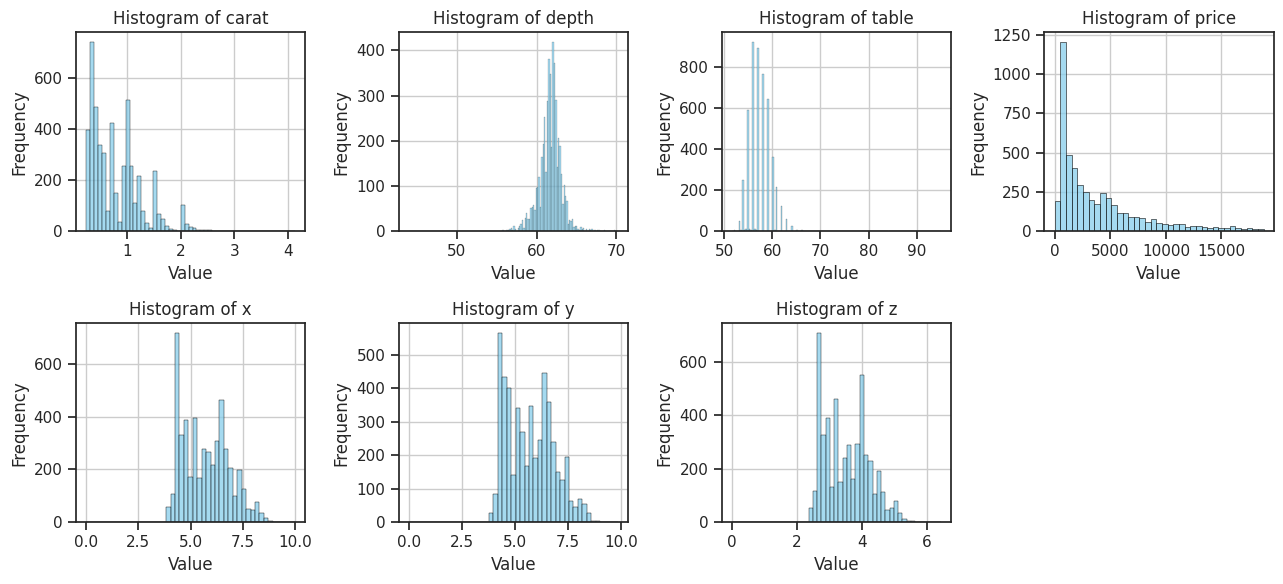

In [52]:
# histograms for numerical features
plt.figure(figsize=(13, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    sns.histplot(data=diamonds_df, x=feature, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {feature}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

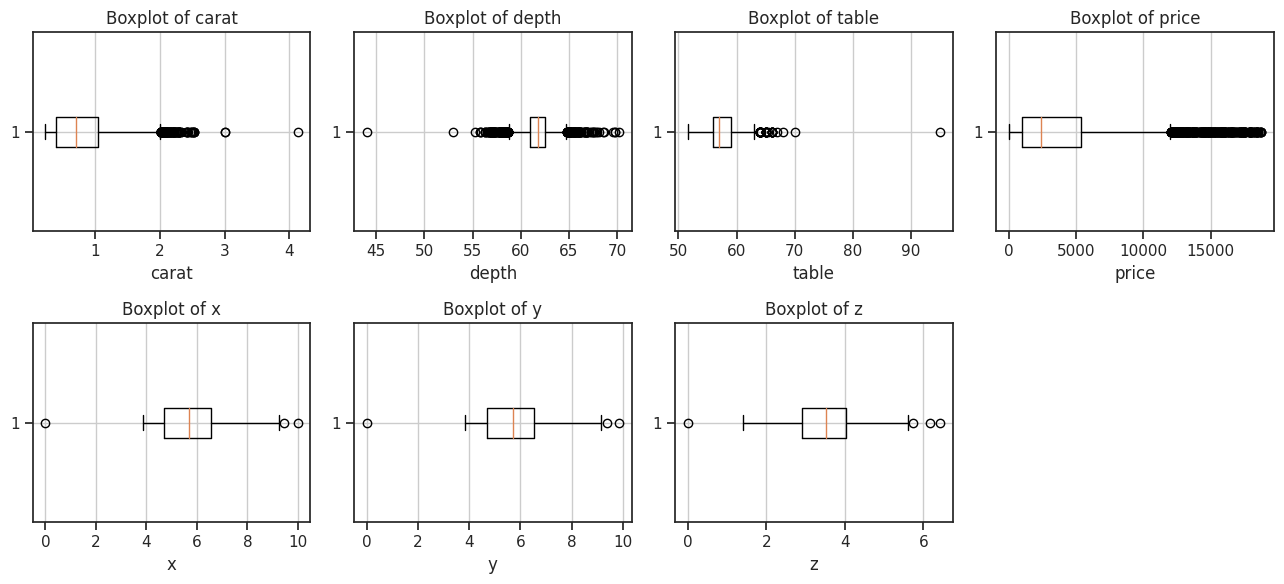

In [53]:
#boxplot for numerical features
plt.figure(figsize=(13, 6))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 4, i +1)
    plt.boxplot(diamonds_df[feature], vert=False)
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.grid(True)


plt.tight_layout()
plt.show()

In [54]:
# Count rows where 'x' and 'y' are equal to 0
count_zero_x = len(diamonds_df[(diamonds_df['x'] == 0) ])
count_zero_y = len(diamonds_df[(diamonds_df['y'] == 0) ])
print(count_zero_x, count_zero_y)

# Select rows with values equal to 0
null_df= diamonds_df[(diamonds_df == 0).any(axis=1)]
null_df

1 1


,carat,cut,color,clarity,depth,table,price,x,y,z
4321,2.25,Premium,H,SI2,62.8,59.0,18034,0.0,0.0,0.0


The intuition about the round diamond is not verified: there is only one entry with 'x' and 'y' values equal to 0.


It is possible to remove it since it will not affect much the overall dataset distribution.

In [55]:
#Delete rows with values =0
diamonds_df = diamonds_df[~(diamonds_df == 0).any(axis=1)]
len(diamonds_df)

4999

Remove the duplicate entries if exist.

In [56]:
#Find duplicate entries
duplicates = diamonds_df[diamonds_df.duplicated()]

#Delete duplicates
diamonds_df = diamonds_df.drop_duplicates()
print(duplicates,'\n', diamonds_df)

      carat      cut color clarity  depth  table  price     x     y     z
4943   0.31  Premium     E     VS2   61.6   59.0    872  4.35  4.32  2.67 
       carat        cut color clarity  depth  table  price     x     y     z
0      1.10      Ideal     H     SI2   62.0   55.0   4733  6.61  6.65  4.11
1      1.29      Ideal     H     SI1   62.6   56.0   6424  6.96  6.93  4.35
2      1.20    Premium     I     SI1   61.1   58.0   5510  6.88  6.80  4.18
3      1.50      Ideal     F     SI1   60.9   56.0   8770  7.43  7.36  4.50
4      0.90  Very Good     F     VS2   61.7   57.0   4493  6.17  6.21  3.82
...     ...        ...   ...     ...    ...    ...    ...   ...   ...   ...
4995   0.38      Ideal     H    VVS2   62.3   53.3    832  4.65  4.69  2.91
4996   0.33    Premium     G    VVS2   61.3   59.0    927  4.45  4.42  2.72
4997   1.25      Ideal     J    VVS2   62.1   56.0   5980  6.81  6.84  4.24
4998   0.31    Premium     F     VS2   62.9   58.0    802  4.31  4.27  2.70
4999   0.30   

## Categorical Features overview

 Categorial features countplots are shown below. Bins are ordered accordingly to the corresponding scale.

cut:['Ideal' 'Premium' 'Very Good' 'Good' 'Fair']
color:['H' 'I' 'F' 'G' 'E' 'D' 'J']
clarity:['SI2' 'SI1' 'VS2' 'IF' 'VVS2' 'VS1' 'I1' 'VVS1']


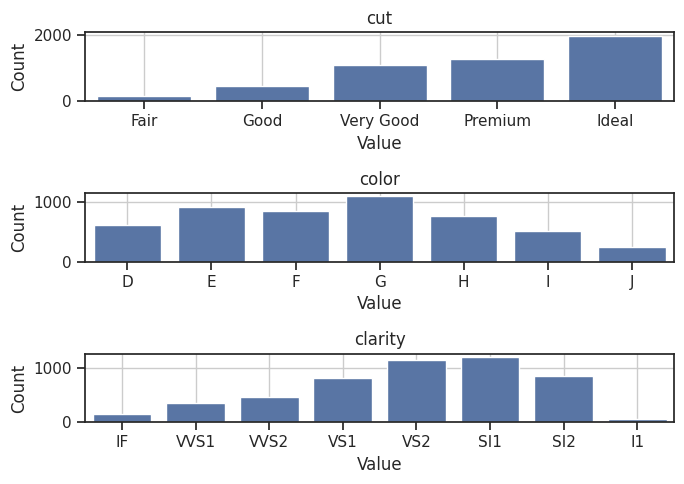

In [57]:
# Countplot for categorical features
for i,feature in enumerate(categorical_features):
  order =  diamonds_df[feature].unique()
  print(f"{feature}:{order}" )

plt.figure(figsize=(7, 5))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 1, i + 1)

    if feature == 'color':
      #Order alphabetically
      o = sorted(diamonds_df[feature].unique())
    elif feature == 'clarity':
      #Order the bins as the clarity scale
      o = [ 'IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
    elif feature == 'cut':
      #Order the bins as the cut scale, just reverse it
      o =  diamonds_df[feature].unique()[::-1]

    sns.countplot(data=diamonds_df, x=feature, order=o)
    plt.title(f'{feature}')
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.grid(True)

plt.tight_layout()
plt.show()



In [58]:
#Compute percentage of 'Ideal' class in 'cut' feature
filtered_data = diamonds_df[diamonds_df['cut'] == 'Ideal']
len(filtered_data)/len(diamonds_df)

0.3985594237695078

All the categorical features are inbalanced (class frequencies are uneven), we might need to weight the loss.

For the 'cut' feature the Ideal class occupies the 40% of the data

For the 'color' feature the most frequent class is G ( Near Colorless)

For the 'clarity' feature the most frequent classes are VS2 - Very slightly included, second degree and SI1 - Slightly included, first degree.

TODO check how to solve this or ignore this

PVALUE

BOXPLOTS

SCATTERPLOTS

REMOVE OUTLIERS

<ipython-input-59-825751ff7f3b>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




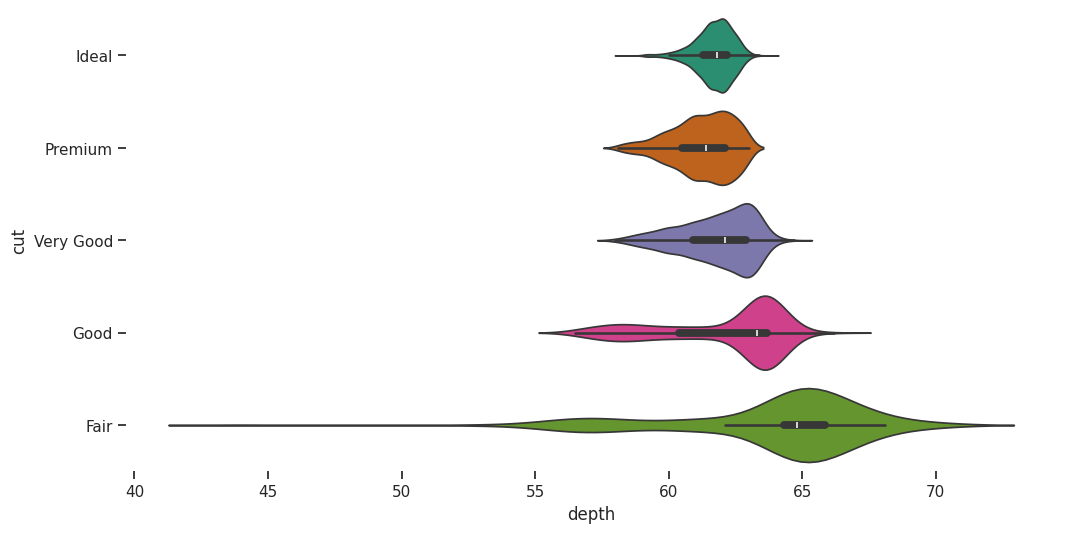

In [59]:
# @title cut vs depth

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(diamonds_df['cut'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(diamonds_df, x='depth', y='cut', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Scatterplots and correlation

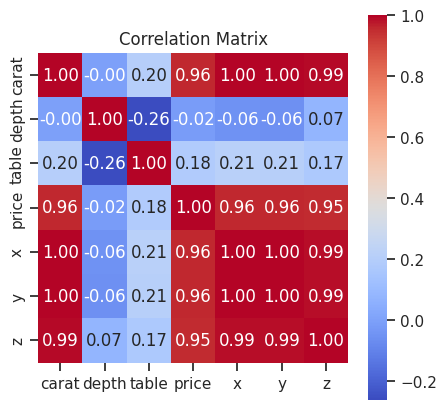

In [60]:
#Correlation matrix
numerical_features = diamonds_df.select_dtypes(include='number')
correlation_matrix = numerical_features.corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

In the plot above, the correlation between numerical features is shown.

Correlation values above 0.8 are considered as an index of strong positive correlation between two variables.

We observe that:
- carat is strongly correlated to x,y,z, dimensions. It makes sense since the carat represent the weight of the diamond, bigger dimension implies higher weight (with same density).
- Dimensions are strongly correlated each other.
- Price is strongly correlated to carat.
- Is curios that table and depth are not strongly correlated to x and z.

In conclusion x,y,z, can be removed from the dataset

<Figure size 100x100 with 0 Axes>

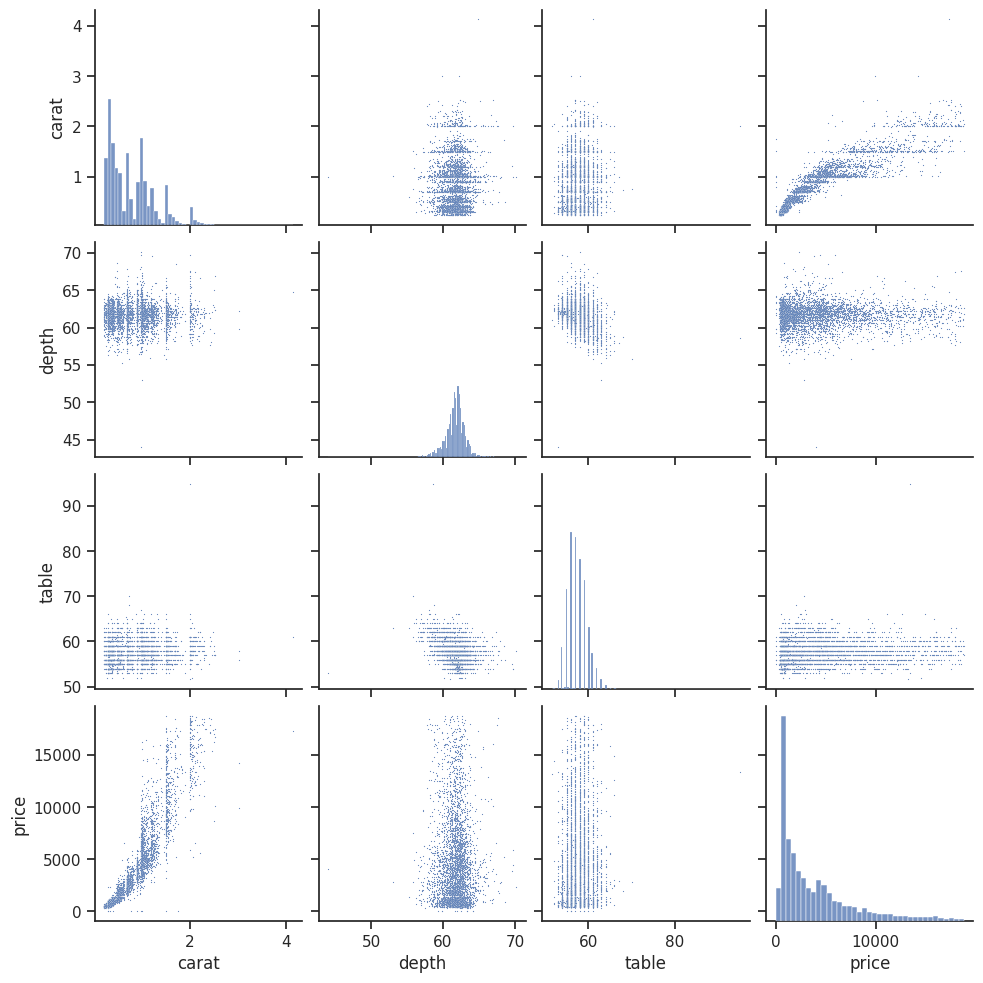

In [61]:
#Drop x y z features
reduced_diamonds_df = diamonds_df.drop(['x', 'y', 'z'], axis=1)

plt.figure(figsize=(1, 1))
marker_size = 0.7
sns.set(style="ticks")
sns.pairplot(reduced_diamonds_df, plot_kws={'s': marker_size})
plt.show()

After 2, the carat dimension is dispersed, we can see outliers

## Price vs Carat

At some point, the strong correlation between carat and price is lost,

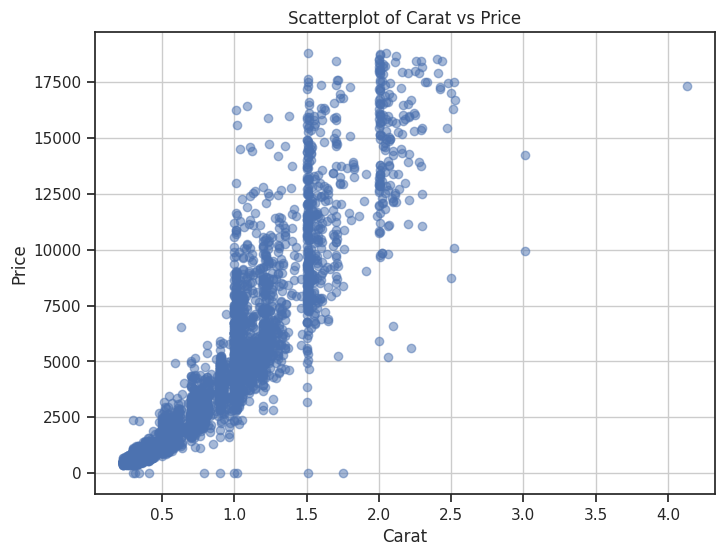

In [62]:
# Create a scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(diamonds_df['carat'], diamonds_df['price'], alpha=0.5)
plt.title('Scatterplot of Carat vs Price')
plt.xlabel('Carat')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## Price vs categorical features

# Data processing
Put here the core of the notebook. Feel free to further split this section into subsections.

## Clean and preprocess the data





Dataset split to test the performances of the model:

- 80% training
- 20% test to perform an evaluation that simulated realworld scenarios

## EVALUATION METRICS
RMSE
plotta grafico con actual vs predicted e riga bisettrice
sulla x e la y i prezzi attuali e predetti

# References:

[Jovian](https://jovian.com/ashishdotc4/gemstone-price-prediction-using-linear-regression)

[GEMO](https://www.researchgate.net/publication/375647223_Gemo_An_AI-Powered_Approach_to_Color_Clarity_Cut_Prediction_and_Valuation_for_Gemstones)

2. author2, article2, journal2, year2, url2